In [1]:
import gym
from collections import defaultdict, deque
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import tensorflow as tf
from keras import Sequential, layers, optimizers
from keras.utils.vis_utils import plot_model
import random
import Box2D
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
env_id = 'LunarLander-v2'
env = gym.make(env_id)

In [3]:
env.observation_space #continuous with 8 observations for each state

Box(8,)

In [4]:
env.action_space #discrete with 4 actions

Discrete(4)

### Launchpad position: (0, 0)

### State Space:
<ol>
    <li>X position</li>
    <li>Y Position</li>
    <li>Linear Velocity (X)</li>
    <li>Linear Velocity (Y)</li>
    <li>Lander Angle</li>
    <li>Scaled Angular Velocity</li>
    <li>(bool) leg 0 (right) made contact, 1 = True</li>
    <li>(bool) leg 1 (left) made contact, 1 = True</li>
</ol>

### Action Space:
<ol>
    <li>Do nothing</li>
    <li>Fire Left Orientation Engine</li>
    <li>Fire Main Engine</li>
    <li>Fire Right Orientation Engine</li>
</ol>

### Reward Scheme: 
<ol>
    <li>Crash: -100</li>
    <li>Rest: +100</li>
    <li>Contact: +10 (each leg)</li>
    <li>Main Engine: -0.3/frame</li>
    <li>Side Engine: -0.03/frame</li>
    <li>Solved: 200</li>
</ol>

##### Episode will terminate if the agent either crashes (-100) or lands (+100). Infinite timesteps (still episodic)

#### Solved if reward of 200 over 100 consecutive trials

### Running an agent using equirprobable random policy π

In [5]:
env.reset()
total_reward = 0
for i in range(1000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    total_reward += reward
    #env.render() #sudo-human
    if(done):
        break
print("Reward: {}\nIteration #: {}\nEnding state:\n{}".format(reward, i, state))

Reward: -100
Iteration #: 71
Ending state:
[ 0.087887   -0.04105749  0.18367979 -0.8844754   0.02087746 -4.8597927
  1.          0.        ]


In [6]:
class DQNAgent():
    def __init__(self, env, buffer_len=10_000, gamma=1.0, mini_batch_size=64, MIN_MEMORY_REPLAY_SIZE=5000, UPDATE_TARGET_EVERY=5):
        
        #get action and state size
        self.action_size = env.action_space.n#4
        self.state_size = env.observation_space.shape[0]#8

        #Discounted Return
        self.gamma = gamma
        
        #Main Model (Q)
        self.model = self.create_model() #build model with 3 hidden layers (L1, L2 = 32; output = 4 hidden units)
        
        # Target Network
        self.target_model = self.create_model() #(Q-target)
        self.target_model.set_weights(self.model.get_weights()) #initialize TD target with same weight as Q.
        
        #Experience Replay
        self.memory_replay = deque(maxlen=buffer_len) #initialize experience replay buffer (circular)
        self.MIN_MEMORY_REPLAY_SIZE = MIN_MEMORY_REPLAY_SIZE
        #Define mini-batch size for learning
        self.batch_size = mini_batch_size
        
        #Fixed Q target counter
        self.target_update_counter = 0 #responsible for updating the target network with the main model
        self.UPDATE_TARGET_EVERY = 5
    def create_model(self):
        model = Sequential() #initialize the model
        model.add(layers.Dense(32, activation='relu', input_shape=(self.state_size,)))#dense layer with 32 units
        model.add(layers.Dropout(0.2)) #keep_probs = 0.8
        model.add(layers.Dense(32, activation='relu')) #dense layer with 32 hidden units
        model.add(layers.Dropout(0.2)) #keep_probs = 0.8
        model.add(layers.Dense(self.action_size, activation='linear')) #output layer with 4 units
        model.compile(loss='mse', optimizer=optimizers.Adam(), metrics=['accuracy'])
        return model
    
    def get_config(self):
        return self.model.get_weights()
    
    def graph_model(self, path="model.png", layer_names=True, shapes=True):
        return plot_model(model=self.model, to_file=path, show_layer_names=layer_names, show_shapes=shapes)
    
    def update_experience_replay(self, transition):
        #transition = (state, action, reward, next_state, done) SARS'_done
        return self.memory_replay.append(transition) #store observed state-action tuples in replay memory.
    
    def fetch_Q(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape))[0] #Target Q essentially = Q-table.
    
    def train(self, terminal_state):
        
        # Start training only if certain number of samples is already saved
        if len(self.memory_replay) < self.MIN_MEMORY_REPLAY_SIZE:
            return
        
        minibatch = random.sample(self.memory_replay, self.batch_size) #array of transition tuples
        #Remember: tranisition unfolded = (state, action, reward, next_state, done)
        states = np.array([transition[0] for transition in minibatch]) 
        current_Q_list = self.model.predict(states)
        
        new_current_states = np.array([transition[3] for tranistion in minibatch])
        future_Q_list = self.target_model.predict(new_current_states)
        
        X = []; y = []
        
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            #perform SGD in here & update param
            
            if not done:
                sarsa_max = np.argmax(future_Q_list[i]) # q̂(S', A, w) -or- q̂(S', A, ϴ)
                td_target = reward + self.gamma*sarsa_max
            else:
                td_target = reward
            
            #Update Q value for given state
            current_Qs = current_Q_list[i] #get Q(s, a ∈ A)
            current_Qs[action] = td_target
            
            #append to training set
            X.append(state)
            y.append(current_Qs)
            
            # Fit on all samples as one batch
            self.model.fit(np.array(X), np.array(y), batch_size=self.batch_size, verbose=0, shuffle=False)
            
            # Update target network counter every episode
            if terminal_state:
                self.target_update_counter += 1
            
            # If counter reaches set value, update target network with weights of main network
            if self.target_update_counter > self.UPDATE_TARGET_EVERY:
                self.target_model.set_weights(self.model.get_weights())
                self.target_update_counter = 0

    def get_action(self, state, epsilon):
        if(np.random.rand() > epsilon): #exploit
            action = np.argmax(self.fetch_Q(state))
        else: #explore
            action = np.random.choice(np.arange(self.action_size))
        return action

In [7]:
agent = DQNAgent(env)

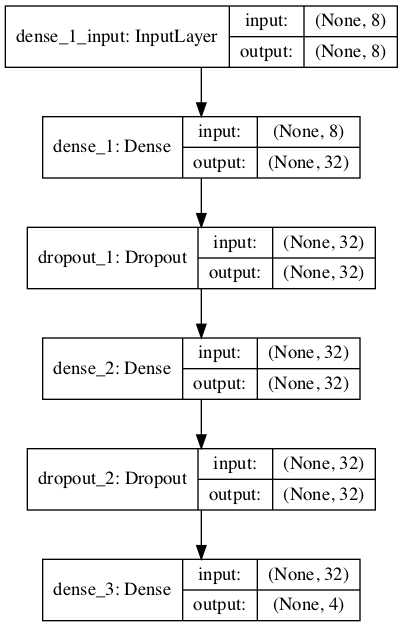

In [8]:
agent.graph_model()

In [9]:
weights_agent = np.array(agent.get_config())

In [10]:
NUM_EPISODES = 150
epsilon_start = 1.0
epsilon_decay_rate = 0.99
epsilon_min = 0.5

In [11]:
episode_reward_arr = []

In [ ]:
epsilon = epsilon_start
for episode_num in tqdm(range(1, NUM_EPISODES + 1)):
        #Reset episode reward and step count
        episode_reward = 0 #reward at the end of each episode (should decrease, otherwise something is wrong)
        step = 1
        
        state = env.reset()
        
        while True:
            action = agent.get_action(state, epsilon)
            next_state, reward, done, _ = env.step(action) #step into next state
            episode_reward += reward #count reward
            
            #update experience replay buffer
            transition = (state, action, reward, next_state, done) #SARS'_done
            agent.update_experience_replay(transition)
            
            #train the model
            agent.train(done)
            
            #update state and step count
            state = next_state
            step += 1
            
            #terminal state reached
            if(done):
                episode_reward_arr.append(episode_reward)
                break
        
        #Decay epsilon
        epsilon *= epsilon_decay_rate
        epsilon = max(epsilon, epsilon_min)

 40%|████      | 60/150 [02:37<17:26, 11.63s/it]

In [ ]:
df = pd.DataFrame(data=episode_reward_arr, columns=['Reward'])

In [ ]:
df.plot()

In [ ]:
rolling_mean = df.rolling(10, win_type='triang').sum()

In [ ]:
rolling_mean.plot()

In [ ]:
df.mean()